In [ ]:
%pip install --user sklearn
%pip install --user numpy
%pip install --user matplotlib

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [39]:
def confusion_matrix(model, X, y):
        
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        for i in range(0, len(X)):

            pred = model.predict(X[i].reshape(1, -1))[0]

            if pred == 1 and y[i] == 1:
                tp+=1
            elif pred == 1 and y[i] == 0:
                fp+=1
            elif pred == 0 and y[i] == 0:
                tn+=1
            else:
                fn+=1
        
        return tp, fp, tn, fn

def count_occurences(y):
    ones=0
    zeroes=0
    
    for i in range(0,len(y)):
        if y[i] == 1:
            ones+=1
        else:
            zeroes+=1
    return ones, zeroes

In [43]:
data_matrix = np.loadtxt(open("./msd_genre_dataset/msd_genre_dataset_segpreproc_knime.csv", "rb"), delimiter=";", skiprows=1)

#Los datos del set de datos están agrupados por género. Es decir, primero están todas las filas que corresponden
#a 1 y después todas las que corresponden a 0. Se hace un shuffle para que, más tarde, en cross-validation
#no se creen unos modelos que predigan únicamente una clase.
np.random.shuffle(data_matrix)

print("Filas de la matriz: " + str(len(data_matrix)))
print("Columnas de la matriz: " + str(len(data_matrix[0])))

X = np.resize(data_matrix, (len(data_matrix), len(data_matrix[0])-1))
y = data_matrix[:,len(data_matrix[0])-1]

#Se intenta estandarizar X para lograr mejor desempeño. Sin embargo, no parece funcionar.
X = MinMaxScaler().fit_transform(X)

print("X shape" + str(X.shape))
print("y shape" + str(y.shape))

Filas de la matriz: 8350
Columnas de la matriz: 31
X shape(8350, 30)
y shape(8350,)


In [3]:
percentage_test = 0.2

#Porcentaje de datos dedicados a validación, relativo al número de daots de test
percentage_validation = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage_test) 

In [41]:
one, zero = count_occurences(y_train)

print("ones: %s| zeroes: %s" % (one, zero))

ones: 3464| zeroes: 3216


In [4]:
kf = KFold(n_splits=math.floor(1/percentage_validation))

n_max = 100
scores = []
best_neurons=0
best_score=1

for n in range(2, n_max+1, 5):

    i=0
    score=0

    #Validación cruzada de la red neuronal
    for train_index, test_index in kf.split(X):
        X_train_cv, X_validate = X[train_index], X[test_index]
        y_train_cv, y_validate = y[train_index], y[test_index]
        net = MLPClassifier(solver='sgd', alpha=0.000005,hidden_layer_sizes=(n,), random_state=1)
        net.fit(X_train_cv,y_train_cv)
    
        score+=net.score(X_validate, y_validate)
        i+=1
    
    score = 1- (score/i)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_neurons = n
    
    print("Average error probability for %s neurons in one hidden layer: %s" % (n, score))

print("Lowest error probability: %s for model with %s neurons" % (best_score, best_neurons))




Average error probability for 2 neurons in one hidden layer: 0.48083832335329346
Average error probability for 7 neurons in one hidden layer: 0.4929341317365269
Average error probability for 12 neurons in one hidden layer: 0.49401197604790426
Average error probability for 17 neurons in one hidden layer: 0.4797604790419161
Average error probability for 22 neurons in one hidden layer: 0.4819161676646706
Average error probability for 27 neurons in one hidden layer: 0.48275449101796397
Average error probability for 32 neurons in one hidden layer: 0.48263473053892214
Average error probability for 37 neurons in one hidden layer: 0.48574850299401207
Average error probability for 42 neurons in one hidden layer: 0.48167664670658683
Average error probability for 47 neurons in one hidden layer: 0.48634730538922155
Average error probability for 52 neurons in one hidden layer: 0.48598802395209584
Average error probability for 57 neurons in one hidden layer: 0.4846706586826347
Average error probabil

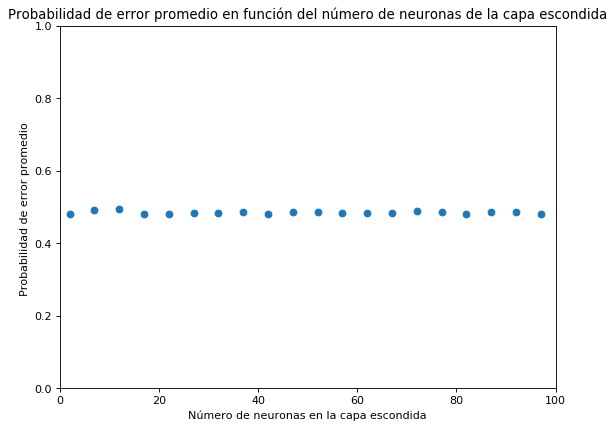

In [5]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(2, n_max, 5), scores, 'o')
plt.axis([0, 100, 0, 1])
plt.xlabel('Número de neuronas en la capa escondida')
plt.ylabel('Probabilidad de error promedio ')
plt.title('Probabilidad de error promedio en función del número de neuronas de la capa escondida')
plt.show()

In [40]:
#Ahora se entrena el mejor modelo con todos los datos de entrenamiento y se prueban los datos de validación

final_classifier = MLPClassifier(solver='sgd', alpha=0.000005,hidden_layer_sizes=(best_neurons,), random_state=1)
final_classifier.fit(X_train, y_train)

print("Probabilidad de error del modelo con %s neuronas en una capa escondida: %s" 
      % (best_neurons, 1-final_classifier.score(X_test, y_test)))

tp, fp, tn, fn = confusion_matrix(final_classifier, X_test, y_test)
print("TP: %s|FP: %s|TN: %s|FN: %s|" % (tp, fp, tn, fn))

one, zero = count_occurences(y_test)

print("ones: %s| zeroes: %s" % (one, zero))

Probabilidad de error del modelo con 17 neuronas en una capa escondida: 0.4784431137724551
TP: 803|FP: 732|TN: 68|FN: 67|
ones: 870| zeroes: 800


In [32]:
#Ahora, se toma el número de neuronas con mayor desempeño en una capa escondida y, con este número de neuronas, 
#se prueban n capas escondidas entre 2 y 100 a intervalos de 5.

kf = KFold(n_splits=math.floor(1/percentage_validation))

n_max = 20
hl_scores = []
best_layers=0
best_score=1

hid_tuple = ()

for n in range(2, n_max+1, 1):
    
    #Ahora expande la tupla, insertando best_neurons n veces hasta llegar a n
    
    hid_tuple = list(hid_tuple)
    while len(hid_tuple) != n:
        hid_tuple.append(best_neurons)
    
    hid_tuple = tuple(hid_tuple)

    i=0
    score=0

    #Validación cruzada de la red neuronal
    for train_index, test_index in kf.split(X):
        X_train_cv, X_validate = X[train_index], X[test_index]
        y_train_cv, y_validate = y[train_index], y[test_index]
        net = MLPClassifier(solver='sgd', alpha=0.000005,hidden_layer_sizes=hid_tuple, random_state=1)
        net.fit(X_train_cv,y_train_cv)
    
        score+=net.score(X_validate, y_validate)
        i+=1
    
    score = 1- (score/i)
    hl_scores.append(score)
    
    if score < best_score:
        best_score = score
        best_layers = n
    
    print("Average error probability for %s neurons in %s hidden layers: %s" % (best_neurons, n,score))
    
    
print("Lowest error probability: %s for model with %s hidden layers" % (best_score, best_layers))



Average error probability for 17 neurons in 2 hidden layers: 0.48299401197604797
Average error probability for 17 neurons in 3 hidden layers: 0.48107784431137735
Average error probability for 17 neurons in 4 hidden layers: 0.4805988023952096
Average error probability for 17 neurons in 5 hidden layers: 0.48083832335329346
Average error probability for 17 neurons in 6 hidden layers: 0.4809580838323354
Average error probability for 17 neurons in 7 hidden layers: 0.4809580838323354
Average error probability for 17 neurons in 8 hidden layers: 0.4809580838323354
Average error probability for 17 neurons in 9 hidden layers: 0.4809580838323354
Average error probability for 17 neurons in 10 hidden layers: 0.4809580838323354
Average error probability for 17 neurons in 11 hidden layers: 0.4809580838323354
Average error probability for 17 neurons in 12 hidden layers: 0.4809580838323354
Average error probability for 17 neurons in 13 hidden layers: 0.4809580838323354
Average error probability for 17 

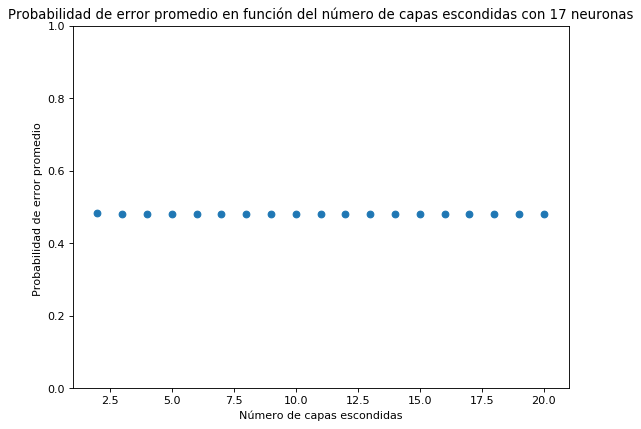

In [37]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(2, n_max+1, 1), hl_scores, 'o')
plt.axis([1, 21, 0, 1])
plt.xlabel('Número de capas escondidas')
plt.ylabel('Probabilidad de error promedio ')
plt.title('Probabilidad de error promedio en función del número de capas escondidas con %s neuronas' 
          % best_neurons)
plt.show()

In [36]:
#Ahora se entrena el mejor modelo con todos los datos de entrenamiento y se prueban los datos de validación

hid_tuple_final = ()
hid_tuple_final = list(hid_tuple_final)

while len(hid_tuple_final) != best_layers:
    hid_tuple_final.append(best_neurons)
    
hid_tuple_final = tuple(hid_tuple_final)

final_classifier = MLPClassifier(solver='sgd', alpha=0.000005,hidden_layer_sizes=hid_tuple_final, random_state=1)
final_classifier.fit(X_train, y_train)

print("Probabilidad de error del modelo con %s neuronas en %s capas escondida: %s" 
      % (best_neurons, best_layers, 1-final_classifier.score(X_test, y_test)))

tp, fp, tn, fn = confusion_matrix(final_classifier, X_test, y_test)
print("TP: %s|FP: %s|TN: %s|FN: %s|" % (tp, fp, tn, fn))

Probabilidad de error del modelo con 17 neuronas en 4 capas escondida: 0.47904191616766467
TP: 870|FP: 800|TN: 0|FN: 0|
